# Convolution

In this notebook we will see how to perform discrete convolutions using the Toeplitz tensor.

In [1]:
import numpy as np
from trainsum.numpy import trainsum as ts
import matplotlib.pyplot as plt

opts = ts.variational(max_rank=10, cutoff=1e-10)
ts.set_options(opts)

opts = ts.cross(max_rank=20, eps=0.0)
ts.set_options(opts)

First we set some global options so we do not need context manager for every operation

In [2]:
# define the problem domain
dim = ts.dimension(1024)
shape = ts.trainshape(1024)
domain = ts.domain(0, 1)
grid = ts.uniform_grid(dim, domain)

The first example will be one dimensional so we define a simple uniformly spaced 1D grid with 1024 points.

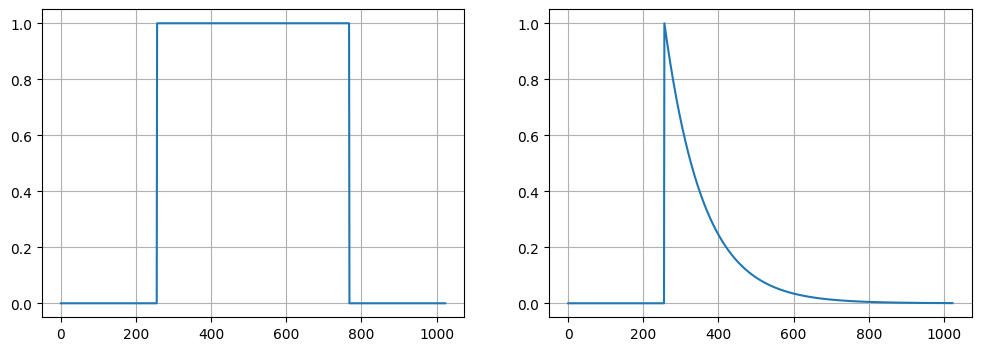

In [3]:
# create a square and exponential function
square = (ts.shift(dim, -256)) @ (ts.shift(dim, 2*256) @ ts.full(shape, 1.0))
exp = ts.shift(dim, -256) @ ts.exp(grid, -10.0, 0.0)

# visualize the functions
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(square.to_tensor())
ax[0].grid()
ax[1].plot(exp.to_tensor())
ax[1].grid()
plt.show()

Having defined the grid we can define two simple function that are textbook examples for explaining a
convolution. On the left we have a simple square function. On the right is a exponential decay of some kind.

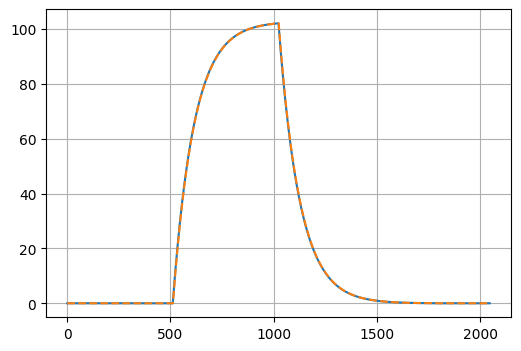

In [4]:
# create the convolution operator
toeplitz = ts.toeplitz(dim, mode="full")

# apply the convolution operator
res = ts.einsum("ijk,j,k->i", toeplitz, exp, square)

# calculate the reference
ref = np.convolve(square.to_tensor(), exp.to_tensor())

# plot the results
plt.figure(figsize=(6,4))
plt.plot(ref)
plt.plot(res.to_tensor(), linestyle="dashed")
plt.grid()
plt.show()

In this cell we construct the 3D toeplitz tensor with rank=2. After that we use the einstein summation
"ijk,j,k->i" to perform the convolution. Finally we compare the result against NumPy's convolve function.

In [5]:
# define the problem domain
shape = ts.trainshape(1024, 1024)
dims = shape.dims
domains = ts.domain(-10, 10), ts.domain(-10, 10)
grid = ts.uniform_grid(dims, domains)

Next we want to perform a 2D convolution, so we create a 2D grid.

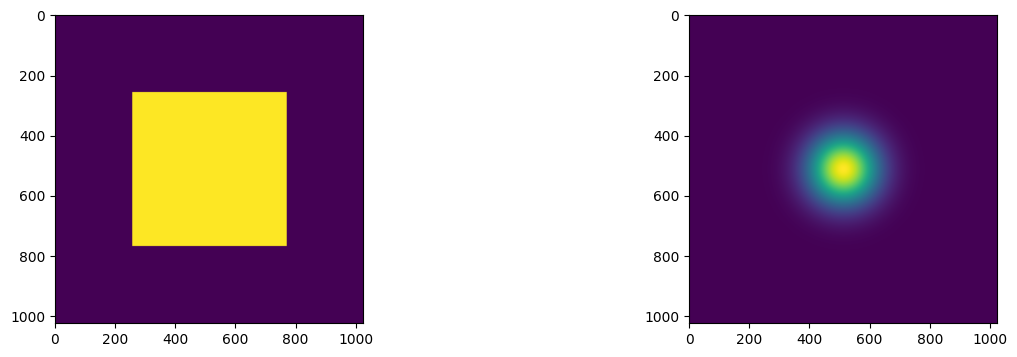

In [6]:
#create a picture with a square
train = ts.full(shape, 1.0)
op = ts.shift(dims[0], -256) @ ts.shift(dims[0], 2*256)
train = ts.einsum("ij,jk->ik", op, train)
train = ts.einsum("ij,kj->ki", op, train)

# learn the gaussian kernel
func = lambda idxs: np.exp(-0.2*np.sum(grid.to_coords(idxs)**2, axis=0))
kernel = ts.tensortrain(shape, func)

# plot the picture and the guassian kernel
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
ax[0].imshow(train.to_tensor())
ax[1].imshow(kernel.to_tensor())
plt.show()

Using the 2D grid we define a square function and a gaussian-shaped function.

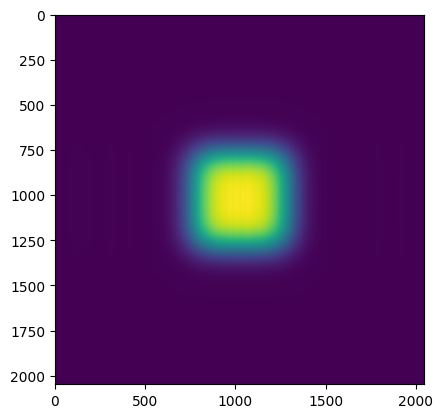

In [7]:
# create the convolution operator
toeplitz = ts.toeplitz(dims[0], mode="full")
toeplitz.extend(ts.toeplitz(dims[1], mode="full"))

# apply the convolution operator
res = ts.einsum("ijkmno,jn,ko->im", toeplitz, train, kernel)

# plot the result
plt.figure()
plt.imshow(res.to_tensor())
plt.show()

Finally we create a multilevel Toeplitz matrix by calculating the outer product of two normal
Toeplitz matrices (using the extend method). After doing so we write down the correct einsum
expression and execute it.